## Training Machine Leaning Model on all Descriptors:

In [1]:

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score)

from random import randint


In [2]:

db1 = pd.read_csv('../../datasets/processed/datasetDFTDescriptors_v2.csv')
db2 = pd.read_csv('../../datasets/processed/datasetRdkitDescriptors_v2.csv')
db3 = pd.read_csv('../../datasets/processed/datasetJazzyDescriptors_v2.csv')
db4 = pd.read_csv('../../datasets/processed/dataset-w-ECFPDescriptors_v2.csv')


In [3]:

newdb1 = db1.drop(['molindx', 'logS', 'Temperature'], axis='columns')
newdb2 = db2.drop(['molindx', 'logS', 'Temperature'], axis='columns')
newdb3 = db3.drop(['molindx', 'logS', 'Temperature'], axis='columns')
newdb4 = db4.drop(['molindx'], axis='columns')


In [4]:

db = pd.concat([newdb1, newdb2, newdb3, newdb4], axis=1)
db.head(3)


,MolarMass,SolvationEnergy,DipoleMoment,MolecularVolume,MolecularSurfaceArea,QXX,QYY,QZZ,HOMO,LUMO,...,1016,1017,1018,1019,1020,1021,1022,1023,Temperature,logS
0,213.1062,49.41304,0.023810,135.223,227.373,-13.222026,-13.391870,26.613896,-8.898476,-3.078875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.614196,5.62659
1,212.1200,55.60536,4.897608,137.044,231.247,-31.386407,15.426680,15.959727,-8.479532,-2.915389,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.635511,7.20786
2,247.5513,48.45072,0.310057,142.857,235.395,21.163466,-9.945875,-11.217591,-8.457148,-3.189701,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.616327,6.27377


In [5]:

target_var = 'logS'

data_new = db.sample(frac=1)
number_of_training = 1


In [ ]:

rnd_state = randint(1, 1000)
train_set, test_set = train_test_split(data_new,
                                       shuffle=True,
                                       random_state=rnd_state,
                                       test_size=0.15)

X_train = train_set.drop(columns=[target_var]).to_numpy()
y_train = train_set[target_var]

X_test = test_set.drop(columns=[target_var]).to_numpy()
y_test = test_set[target_var]

#RF hyperparameters optimization
model = RandomForestRegressor(oob_score=False, random_state = rnd_state)

n_estimators = range(600, 1001, 100)
max_features = np.arange(0.1, 0.99, 0.21)
min_samples_leaf = [2] #[2,3,4]
min_samples_split = [2] #[2,3,4]

parameters = {'n_estimators' : n_estimators,
              'max_features' : max_features,
              'min_samples_leaf' : min_samples_leaf,
              'min_samples_split' : min_samples_split,
             }

#gridsearch cross-validation for model's parameter optimization
rfr = GridSearchCV(model,
                   parameters,
                   cv=10,
                   verbose=1,
                   n_jobs=2,
                   scoring='neg_mean_squared_error')

rfr.fit(X_train, y_train.values.ravel())

model = rfr.best_estimator_
print('Best Model:', model)

y_pred = model.predict(X_test)

# Calculate the MAE
mae = mean_absolute_error(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_test, y_pred)


print(f'Mean Absolute Error: {mae:.2f} (mg/L)')
print(f'Mean Squared Error: {mse:.2f} (mg/L)$^{2}$')
print(f'Root Mean Squared Error: {rmse:.2f} (mg/L)')
print(f'R² Score: {r2:.2f}')


In [ ]:

n_estimators = model.n_estimators
max_features = model.max_features


In [8]:

r2_list = []
mae_list = []
rmse_list = []

for nof_training in range(number_of_training):
    rnd_state = randint(1, 1000)
    train_set, test_set = train_test_split(data_new,
                                           shuffle=True,
                                           random_state=rnd_state,
                                           test_size=0.15)

    X_train = train_set.drop(columns=[target_var]).to_numpy()
    y_train = train_set[target_var]

    X_test = test_set.drop(columns=[target_var]).to_numpy()
    y_test = test_set[target_var]
    
    #RF hyperparameters optimization
    rfr_model = RandomForestRegressor(oob_score=False,
                                      n_estimators=n_estimators,
                                      max_features=max_features,
                                      random_state = rnd_state)

    rfr_model.fit(X_train, y_train.values.ravel())

    y_pred = rfr_model.predict(X_test)

    # Calculate the MAE
    mae = mean_absolute_error(y_test, y_pred)
    mae_list.append(mae)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    rmse_list.append(rmse)

    r2 = r2_score(y_test, y_pred)
    r2_list.append(r2)

mean_mae = np.mean(mae_list)
std_mae = np.std(mae_list)

mean_rmse = np.mean(rmse_list)
std_rmse = np.std(rmse_list)

mean_r2 = np.mean(r2_list)
std_r2 = np.std(r2_list)

print(f'Mean Absolute Error: {mean_mae:.2f} (mg/L) and std of MAE: {std_mae:.2f} (mg/L)')
print(f'Root Mean Squared Error: {mean_rmse:.2f} (mg/L) and std of RMSE: {std_rmse:.2f} (mg/L)')
print(f'R² Score: {mean_r2:.2f} and std of r2: {std_r2:.2f} (mg/L)')


Mean Absolute Error: 1.03 (mg/L) and std of MAE: 0.00 (mg/L)
Root Mean Squared Error: 1.32 (mg/L) and std of RMSE: 0.00 (mg/L)
R² Score: 0.88 and std of r2: 0.00 (mg/L)


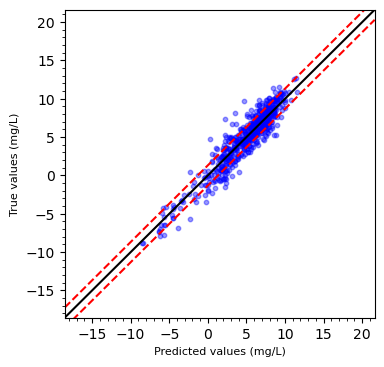

In [9]:

#sctter plot
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(y_pred, np.array(y_test), s=10, c='blue', facecolor='none', alpha=0.4)

ax.set_xlabel('Predicted values (mg/L)', fontsize=8)
ax.set_ylabel('True values (mg/L)', fontsize=8)

ymin = min(y_pred) - 10
ymax = max(y_pred) + 10
ngrids = 100
y_x = np.linspace(ymin, ymax, ngrids) 

ax.xaxis.set_major_locator(MultipleLocator(5))  
ax.yaxis.set_major_locator(MultipleLocator(5)) 

ax.xaxis.set_minor_locator(MultipleLocator(1))  
ax.yaxis.set_minor_locator(MultipleLocator(1))

stdVal = np.ones(ngrids) * np.std(y_test - y_pred)

plt.plot(y_x, y_x, 'k-')
plt.plot(y_x, y_x + stdVal, 'r--')
plt.plot(y_x, y_x - stdVal, 'r--')

plt.xlim(ymin, ymax)
plt.ylim(ymin, ymax)

plt.show()
plt.close()


## OUtlier Analysis ...

In [10]:

db_v1 = pd.read_csv('../../datasets/processed/cleaned_data_v1.csv')
db_v2 = pd.read_csv('../../datasets/processed/cleaned_data_v2.csv')


In [11]:

db_unique = db_v1[~db_v1['SMILES'].isin(db_v2['SMILES'])]
db_unique

,molindx,Name,SMILES,MolarMass,CASNumber,ExperimentalSolubilityInWater,Temperature,ExperimentReference,Datagroup,SolvationEnergy,...,CalMR,TPSA,LabuteASA,BalabanJIndex,BertzCTIndex,Isomer,Aromatic,Cyclic,ChargeNeutral,MadeOfKeyElements
0,0,1.3.5-trichloro-2.4.6-triazine,C1(=NC(=NC(=N1)Cl)Cl)Cl,184.4120,000108-77-0,49791.200000,298.15,Horrobin. S.; Journal of the Chemical Society...,G1,19.37192,...,34.8570,38.67,66.000146,3.165670,175.065178,1,True,True,True,True
2,2,2.4.6-TRINITROBENZOIC ACID,C1=C(C=C(C(=C1[N+](=O)[O-])C(=O)O)[N+](=O)[O-]...,257.1160,000129-66-8,20517.720200,297.15,OChem,G4,69.83096,...,53.3645,166.72,96.711028,3.764179,545.048475,1,True,True,True,True
6,6,1.3.5-Trichloroisocyanuric acid,C1(=O)N(C(=O)N(C(=O)N1Cl)Cl)Cl,232.4103,000087-90-1,11999.285080,298.15,OChem,G4,43.09520,...,42.9750,66.00,79.449639,3.998306,380.520360,1,True,True,True,True
12,12,1.5-ANTHRAQUINONEDISULFONIC ACID,C1=CC2=C(C(=C1)S(=O)(=O)O)C(=O)C3=C(C2=O)C(=CC...,368.3324,000117-14-6,665947.392600,298.15,OChem,G4,95.64624,...,79.3782,142.88,135.792867,2.438976,1035.859570,1,True,True,True,True
13,13,1.3-dioxo-2-benzofuran-5-carboxylic acid,C1=CC2=C(C=C1C(=O)O)C(=O)OC2=O,192.1276,000552-30-7,24400.000000,293.15,https://echa.europa.eu/registration-dossier/-/...,G5,56.44216,...,43.1473,80.67,77.912744,2.607619,460.270160,1,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4601,4601,N-[2-(ethoxy-methylphosphoryl)sulfanylethyl]-4...,CCOP(=O)(C)SCCN(C)C1=CC=C(C=C1)OC,303.3555,041294-05-7,0.320000,303.15,https://echa.europa.eu/registration-dossier/-/...,G5,74.05680,...,83.8785,38.77,119.220887,2.419563,424.401435,2,True,True,True,True
4606,4606,1.4.5.8-TETRAAMINOANTHRAQUINONE,C1=CC(=C2C(=C1N)C(=O)C3=C(C=CC(=C3C2=O)N)N)N,268.2800,002475-45-8,0.030000,298.15,KUROIWA.S & OGASAWARA.S (1973),G2,70.75144,...,77.3986,138.22,113.895157,2.461803,666.746292,1,True,True,True,True
4610,4610,PARAQUAT ION,C[N+]1=CC=C(C=C1)C2=CC=[N+](C=C2)C,188.2700,004685-14-7,620000.000000,293.15,TOMLIN.C (2003),G2,49.03648,...,54.2300,7.76,84.077620,2.396509,371.579647,1,True,True,False,True
4624,4624,5.8-Quinolinedione. dioxime,C1=CC2=C(C=CC(=C2N=C1)NO)N=O,189.1732,082153-77-3,29.995742,298.15,OChem,G4,59.03624,...,52.6072,74.58,79.325582,2.843562,484.440803,1,True,True,True,True


In [12]:

db1 = pd.read_csv('../../datasets/processed/datasetDFTDescriptors.csv')
db2 = pd.read_csv('../../datasets/processed/datasetRdkitDescriptors.csv')
db3 = pd.read_csv('../../datasets/processed/datasetJazzyDescriptors.csv')
db4 = pd.read_csv('../../datasets/processed/dataset-w-ECFPDescriptors.csv')


In [13]:

newdb1 = db1.drop(['molindx', 'logS', 'Temperature'], axis='columns')
newdb2 = db2.drop(['molindx', 'logS', 'Temperature'], axis='columns')
newdb3 = db3.drop(['molindx', 'logS', 'Temperature'], axis='columns')


db = pd.concat([newdb1, newdb2, newdb3, db4], axis=1)
db


,MolarMass,SolvationEnergy,DipoleMoment,MolecularVolume,MolecularSurfaceArea,QXX,QYY,QZZ,HOMO,LUMO,...,1017,1018,1019,1020,1021,1022,1023,molindx,Temperature,logS
0,184.4120,19.37192,0.011313,122.856,184.598,-1.924965,-1.966770,3.891735,-9.082148,-2.137439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.635511,10.81559
1,213.1062,49.41304,0.023810,135.223,227.373,-13.222026,-13.391870,26.613896,-8.898476,-3.078875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.614196,5.62659
2,257.1160,69.83096,2.089799,144.345,245.084,24.193133,-11.286035,-12.907098,-8.523269,-3.264296,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,0.633380,9.92904
3,212.1200,55.60536,4.897608,137.044,231.247,-31.386407,15.426680,15.959727,-8.479532,-2.915389,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.635511,7.20786
4,247.5513,48.45072,0.310057,142.857,235.395,21.163466,-9.945875,-11.217591,-8.457148,-3.189701,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4,0.616327,6.27377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4630,142.1752,77.86424,10.247904,107.168,175.128,21.192957,-19.899548,-1.293410,-6.943367,-0.592385,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4630,0.635511,6.27897
4631,281.2869,83.93104,6.476270,169.383,283.368,30.504208,-26.665339,-3.838869,-7.032441,-0.997393,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4631,0.624853,5.48050
4632,381.0202,88.61712,6.968232,178.290,294.569,37.188032,-23.121464,-14.066568,-6.637029,-0.642856,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4632,0.635511,7.82406
4633,331.3500,118.15616,15.789171,204.470,341.807,101.007733,-61.989119,-39.018613,-5.970921,-1.799127,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4633,0.629116,3.13549


In [14]:
db_outliers = db[db['molindx'].isin(db_unique['molindx'])]
db_outliers

,MolarMass,SolvationEnergy,DipoleMoment,MolecularVolume,MolecularSurfaceArea,QXX,QYY,QZZ,HOMO,LUMO,...,1017,1018,1019,1020,1021,1022,1023,molindx,Temperature,logS
0,184.4120,19.37192,0.011313,122.856,184.598,-1.924965,-1.966770,3.891735,-9.082148,-2.137439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.635511,10.81559
2,257.1160,69.83096,2.089799,144.345,245.084,24.193133,-11.286035,-12.907098,-8.523269,-3.264296,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,0.633380,9.92904
6,232.4103,43.09520,0.095456,132.006,203.192,8.558616,-4.298999,-4.259616,-8.394292,-2.428640,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0.635511,9.39260
12,368.3324,95.64624,3.882281,190.369,315.765,-102.997247,85.059479,17.937768,-8.269131,-3.780466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,0.635511,13.40897
13,192.1276,56.44216,7.773522,130.200,216.056,-16.035798,7.134585,8.901214,-8.229038,-2.787960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,0.624853,10.10234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4601,303.3555,74.05680,6.045111,195.572,339.269,24.533796,-6.529513,-18.004283,-5.094736,-0.007573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4601,0.646169,-1.13943
4606,268.2800,70.75144,0.029418,174.778,295.007,48.670298,-44.562300,-4.107998,-4.945846,-2.355803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4606,0.635511,-3.50656
4610,188.2700,49.03648,0.002433,155.209,261.905,43.535397,-35.598511,-7.936886,-3.552127,0.031509,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4610,0.624853,13.33747
4624,189.1732,59.03624,7.918030,128.227,213.363,-38.828375,41.399826,-2.571452,-5.966853,-2.439977,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4624,0.635511,3.40106


In [15]:
db_ol = db_outliers.drop(['molindx'], axis='columns')
db_ol

,MolarMass,SolvationEnergy,DipoleMoment,MolecularVolume,MolecularSurfaceArea,QXX,QYY,QZZ,HOMO,LUMO,...,1016,1017,1018,1019,1020,1021,1022,1023,Temperature,logS
0,184.4120,19.37192,0.011313,122.856,184.598,-1.924965,-1.966770,3.891735,-9.082148,-2.137439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.635511,10.81559
2,257.1160,69.83096,2.089799,144.345,245.084,24.193133,-11.286035,-12.907098,-8.523269,-3.264296,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.633380,9.92904
6,232.4103,43.09520,0.095456,132.006,203.192,8.558616,-4.298999,-4.259616,-8.394292,-2.428640,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.635511,9.39260
12,368.3324,95.64624,3.882281,190.369,315.765,-102.997247,85.059479,17.937768,-8.269131,-3.780466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.635511,13.40897
13,192.1276,56.44216,7.773522,130.200,216.056,-16.035798,7.134585,8.901214,-8.229038,-2.787960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.624853,10.10234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4601,303.3555,74.05680,6.045111,195.572,339.269,24.533796,-6.529513,-18.004283,-5.094736,-0.007573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.646169,-1.13943
4606,268.2800,70.75144,0.029418,174.778,295.007,48.670298,-44.562300,-4.107998,-4.945846,-2.355803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.635511,-3.50656
4610,188.2700,49.03648,0.002433,155.209,261.905,43.535397,-35.598511,-7.936886,-3.552127,0.031509,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.624853,13.33747
4624,189.1732,59.03624,7.918030,128.227,213.363,-38.828375,41.399826,-2.571452,-5.966853,-2.439977,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.635511,3.40106


In [16]:
X_outlier = db_ol.drop(columns=[target_var]).to_numpy()
y_outlier = db_ol[target_var]

In [17]:

y_pred_ol = rfr_model.predict(X_outlier)


In [18]:

db_ol['Predicted'] = rfr_model.predict(X_outlier)
db_ol


,MolarMass,SolvationEnergy,DipoleMoment,MolecularVolume,MolecularSurfaceArea,QXX,QYY,QZZ,HOMO,LUMO,...,1017,1018,1019,1020,1021,1022,1023,Temperature,logS,Predicted
0,184.4120,19.37192,0.011313,122.856,184.598,-1.924965,-1.966770,3.891735,-9.082148,-2.137439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.635511,10.81559,6.782073
2,257.1160,69.83096,2.089799,144.345,245.084,24.193133,-11.286035,-12.907098,-8.523269,-3.264296,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.633380,9.92904,6.519469
6,232.4103,43.09520,0.095456,132.006,203.192,8.558616,-4.298999,-4.259616,-8.394292,-2.428640,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.635511,9.39260,6.747757
12,368.3324,95.64624,3.882281,190.369,315.765,-102.997247,85.059479,17.937768,-8.269131,-3.780466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.635511,13.40897,3.778334
13,192.1276,56.44216,7.773522,130.200,216.056,-16.035798,7.134585,8.901214,-8.229038,-2.787960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.624853,10.10234,6.914200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4601,303.3555,74.05680,6.045111,195.572,339.269,24.533796,-6.529513,-18.004283,-5.094736,-0.007573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.646169,-1.13943,3.536989
4606,268.2800,70.75144,0.029418,174.778,295.007,48.670298,-44.562300,-4.107998,-4.945846,-2.355803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.635511,-3.50656,4.358366
4610,188.2700,49.03648,0.002433,155.209,261.905,43.535397,-35.598511,-7.936886,-3.552127,0.031509,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.624853,13.33747,5.702510
4624,189.1732,59.03624,7.918030,128.227,213.363,-38.828375,41.399826,-2.571452,-5.966853,-2.439977,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.635511,3.40106,5.042367


In [19]:

#underestimation
gg1 = db_ol[(db_ol['logS'] - db_ol['Predicted'] > 5) & ( db_ol['Predicted'] >=0 ) & ( db_ol['Predicted'] < 7)  & (db_ol['logS'] > 1)]
gg2 = db_ol[(db_ol['logS'] - db_ol['Predicted'] > 5) & ( db_ol['Predicted'] < 0) & (db_ol['logS'] > 0)]

#overestimation
dd1 = db_ol[(db_ol['Predicted'] - db_ol['logS'] > 5) & (db_ol['logS'] >= 0)]
dd2 = db_ol[(db_ol['Predicted'] - db_ol['logS'] > 5) & (db_ol['Predicted'] > 3) & (db_ol['logS'] < 0)]



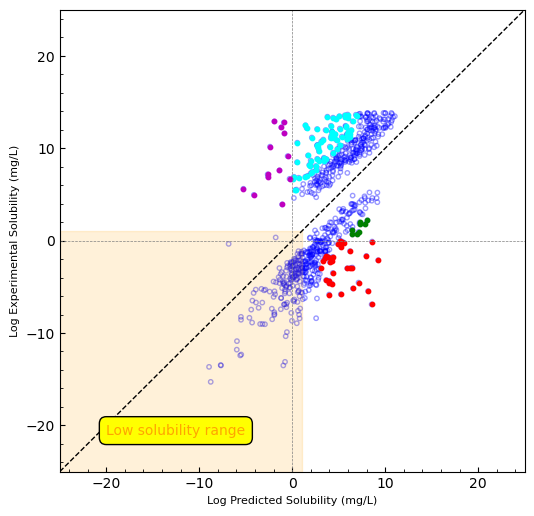

In [31]:
#sctter plot
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig, ax = plt.subplots(figsize=(6, 6))

xx = db_ol['Predicted']
yy = db_ol['logS']

ymin = -25
ymax = 25
ngrids = 100

y_x = np.linspace(ymin, ymax, ngrids)
zeros = np.zeros(ngrids)

lw = 0.5
plt.plot(y_x, y_x, linestyle='--', color='black', linewidth=2*lw)
plt.plot(zeros, y_x, linestyle='--', color='gray', linewidth=lw)
plt.plot(y_x, zeros, linestyle='--', color='gray', linewidth=lw)

ax.scatter(xx, yy, s=10, edgecolors='blue', facecolors='none', alpha=0.4)

ax.scatter(dd1['Predicted'], dd1['logS'], s=10, c='green', facecolor='none', label='dd1')
ax.scatter(dd2['Predicted'], dd2['logS'], s=10, c='red', facecolor='none', label='dd2')

ax.scatter(gg1['Predicted'], gg1['logS'], s=10, c='cyan', facecolor='none', label='gg1')
ax.scatter(gg2['Predicted'], gg2['logS'], s=10, c='m', facecolor='none', label='gg2')

ax.set_xlabel('Log Predicted Solubility (mg/L)', fontsize=8)
ax.set_ylabel('Log Experimental Solubility (mg/L)', fontsize=8)

ax.xaxis.set_major_locator(MultipleLocator(10))  
ax.yaxis.set_major_locator(MultipleLocator(10)) 

ax.xaxis.set_minor_locator(MultipleLocator(2))  
ax.yaxis.set_minor_locator(MultipleLocator(2))

x_min, x_max = -25, 1
y_min, y_max = -25, 1

# Create the vertices of the rectangular region you want to fill
x_coords = [x_min, x_max, x_max, x_min]
y_coords = [y_min, y_min, y_max, y_max]


# Fill the rectangular region where -25 < x < 1 and -25 < y < 0
plt.fill(x_coords, y_coords, color='orange', alpha=0.15)
#plt.text(-23, -20, 'Low Solubility', color='orange', fontweight=550)

plt.text(-20, -21, 'Low solubility range',
         color='orange', fontweight=500,
         bbox=dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.5'))


plt.xlim(ymin, ymax)
plt.ylim(ymin, ymax)

plt.savefig('fig5.pdf', dpi=600, bbox_inches='tight', pad_inches=0.1)
#plt.legend()
plt.show()
plt.close()


In [ ]:

common_indices1 = dd1.index.intersection(db_v1.index)
common_indices1


In [ ]:

common_indices2 = dd2.index.intersection(db_v1.index)
common_indices2


In [ ]:

common_indices3 = gg1.index.intersection(db_v1.index)
common_indices3


In [ ]:

common_indices4 = gg2.index.intersection(db_v1.index)
common_indices4


In [ ]:

df1 = db_v1.loc[common_indices1]

df2 = db_v1.loc[common_indices2]

df3 = db_v1.loc[common_indices3]

df4 = db_v1.loc[common_indices4]


In [ ]:

from rdkit import Chem
from rdkit.Chem import Draw

# Function to convert SMILES to 2D structure and save as SVG
def smiles_to_svg(smiles, file_name='molecule.svg'):
    # Convert SMILES to RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)
    
    if mol:  # If the molecule was successfully generated
        # Generate a 2D structure for the molecule
        Chem.rdDepictor.Compute2DCoords(mol)
        
        # Draw the molecule and save as SVG
        svg = Draw.MolsToGridImage([mol], molsPerRow=1, subImgSize=(300, 300), useSVG=True)
        
        # Write SVG content to file
        with open(file_name, 'w') as f:
            f.write(svg.data)  # Use svg.data to write the SVG content as a string
        print(f'SVG file saved as: {file_name}')
    else:
        print('Invalid SMILES string.')

for idx in df3.index:
    smi = df3['SMILES'][idx]
    print(smi)
    smiles_to_svg(smi, f'{idx}.svg')
